In [1]:
# create a list of colormap we're going to use (size C)

# cluster types (cells / neighborhoods) into <= C types

# within each type, organize types into linear order using linkage and optimal leaf ordering 

# for each type, get it's cmap and position along the cmap. 

In [2]:
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Visualization.Viz import *
import matplotlib.pyplot as plt 

In [3]:
TMG = TissueMultiGraph('TMG_dev5.pkl')

In [99]:
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering
from matplotlib.patches import Wedge, Circle
from matplotlib.collections import PatchCollection

class PolygonColorByType2(View):
    def __init__(self,TMG,name = "polygons / random colors",lvl = 0,metric = 'cosine'):
        super().__init__(TMG,name = f"{name} / level-{lvl}")
        self.lvl = lvl
        self.clr = None
        self.metric = metric
        #self.cmap_list = ['YlOrBr','RdPu','YlGn','PuBu','cividis']
        self.cmap_list = ['Purples','Oranges','Blues','Greens','Reds','cividis']
        # self.cmap_list = ['summer','spring','cool','Wistia']
        
    def set_view(self):
        cell_types = self.TMG.map_to_cell_level(self.lvl)
        
        # build distance matrix
        D = pdist(self.TMG.Layers[self.lvl].feature_type_mat,self.metric)
        Dcosine = squareform(D)
        
        # Breat type graph into 5 color groups
        res = 0.01
        nt2=0; 
        while nt2<len(self.cmap_list): 
            res = res+0.1
            G = buildgraph(Dcosine,metric = 'precomputed',n_neighbors = 10)
            T2 = np.array(G.community_leiden(objective_function='modularity',resolution_parameter = res).membership).astype(np.int64)
            nt2 = len(np.unique(T2))
        
        # subset each group into most distinct colors
        clr = np.zeros((len(T2),4))
        for i in range(len(self.cmap_list)):
            ix = np.flatnonzero(T2==i)
            d = Dcosine[np.ix_(ix,ix)]
            dvec = squareform(d)
            z = linkage(dvec,method='average')
            ordr = optimal_leaf_ordering(z,dvec)
            cmap = cm.get_cmap(self.cmap_list[i])
            n=len(ix)
            shift = np.ceil(0.2*n)
            value = (np.arange(len(ix))+shift+1)/(len(ix)+shift)
            clr[ix,:] = cmap(value)
            
        # create scalar mapping by just using cell_type id
        self.polygon_style['scalar'] = cell_types
        self.clr = clr
        self.type2 = T2
        
        unq,cnt = np.unique(cell_types,return_counts = True)
        self.sz = cnt.astype('float')
        layout = G.layout_fruchterman_reingold()
        xy = np.array(layout.coords)
        xy[:,0] = xy[:,0]-xy[:,0].min()
        xy[:,1] = xy[:,1]-xy[:,1].min()
        xy[:,0] = xy[:,0]/xy[:,0].max()
        xy[:,1] = xy[:,1]/xy[:,1].max()
        
        self.xy = xy
        self.clrmp = ListedColormap(clr)
        
    def plot(self,V1 = None):
        super().plot()
        plt.figure(figsize = (13,13))
        plt.scatter(x = self.xy[:,0],y = self.xy[:,1],c=self.clr,s = self.sz)
        
        if self.lvl==3 and V1 is not None:
            # start new figure (to calc size factor)
            fig = plt.figure(figsize = (13,13))
            ax = plt.gca()
            
            # get fractions and sort by type2
            feature_type_mat = self.TMG.Layers[self.lvl].feature_type_mat
            ordr = np.argsort(V1.type2)
            feature_type_mat = feature_type_mat[:,ordr]
            
            # scale between radi in points to xy that was normed to 0-1
            scale_factor = fig.dpi * 13
            
            xy = self.xy*scale_factor
            radi = np.sqrt(self.sz/np.pi)
            cdf_in_angles = np.cumsum(np.hstack((np.zeros((feature_type_mat.shape[0],1)),feature_type_mat)),axis=1)*360

            wedges = list()
            for i in range(feature_type_mat.shape[0]):
                for j in range(frac.shape[1]):
                    w = Wedge((xy[i,0],xy[i,1]), radi[i], cdf_in_angles[i,j], 
                               cdf_in_angles[i,j+1],facecolor = V1.clr[ordr[j],:])
                    c = Circle((xy[i,0],xy[i,1]),radi[i],edgecolor = self.clr[i,:],linewidth = 0.1*radi[i],fill = False)
                    wedges.append(w)
                    wedges.append(c)


            p = PatchCollection(wedges,match_original=True)
            ax.add_collection(p)

            margins = 0.05
            ax.set_xlim(-margins*scale_factor,(1+margins)*scale_factor)
            ax.set_ylim(-margins*scale_factor,(1+margins)*scale_factor)


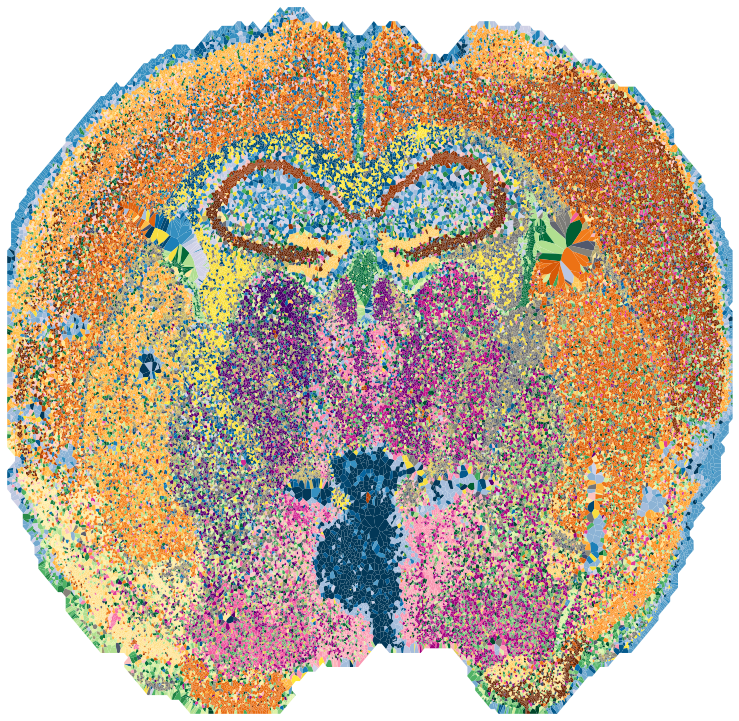

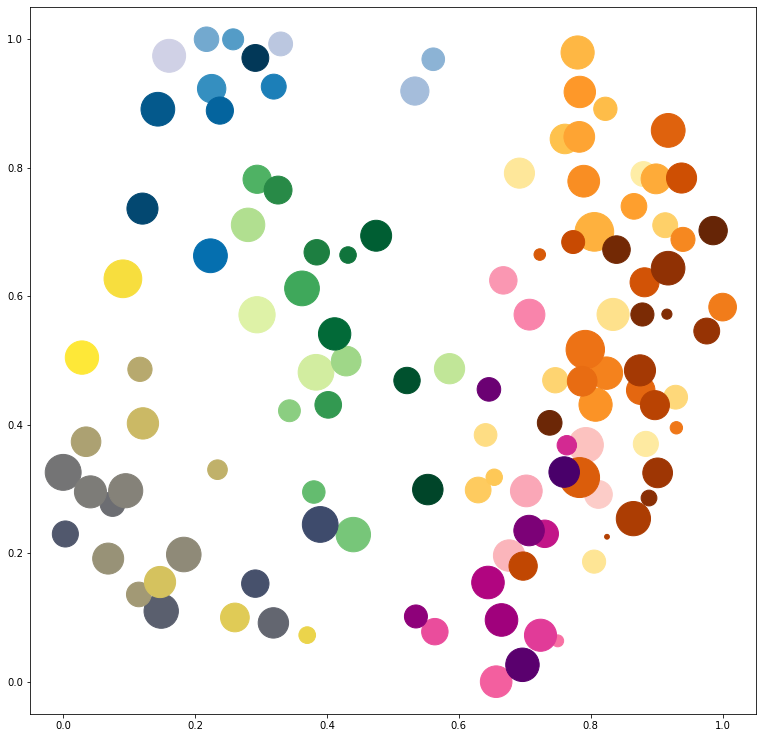

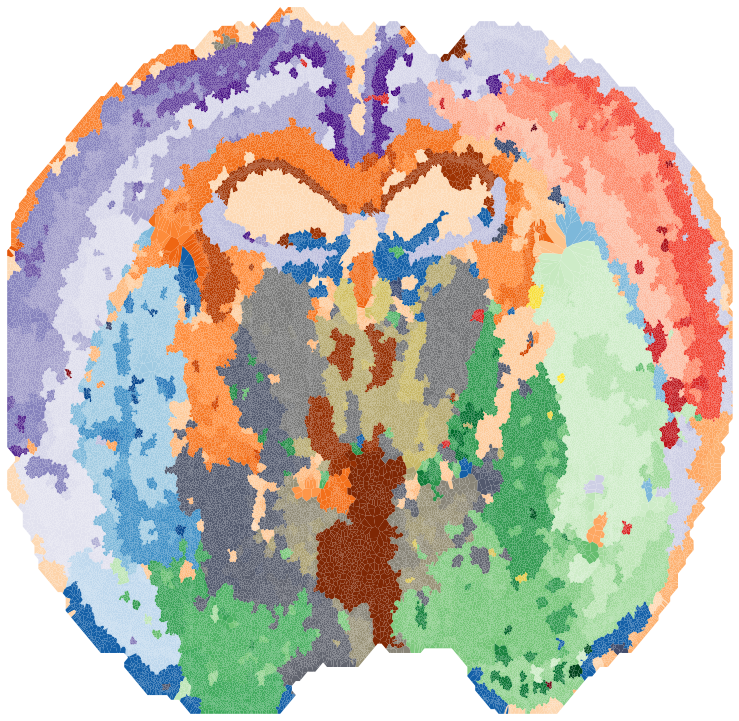

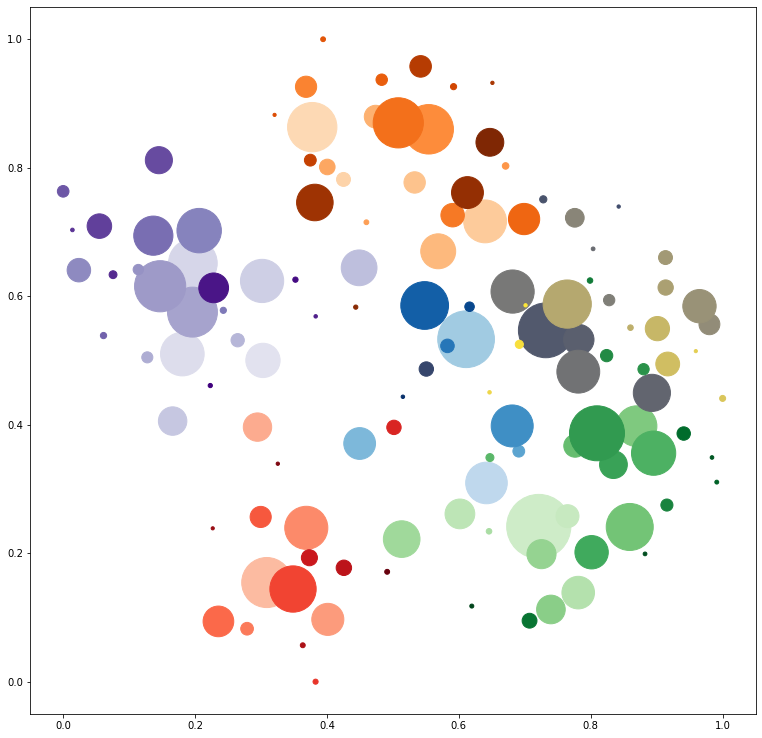

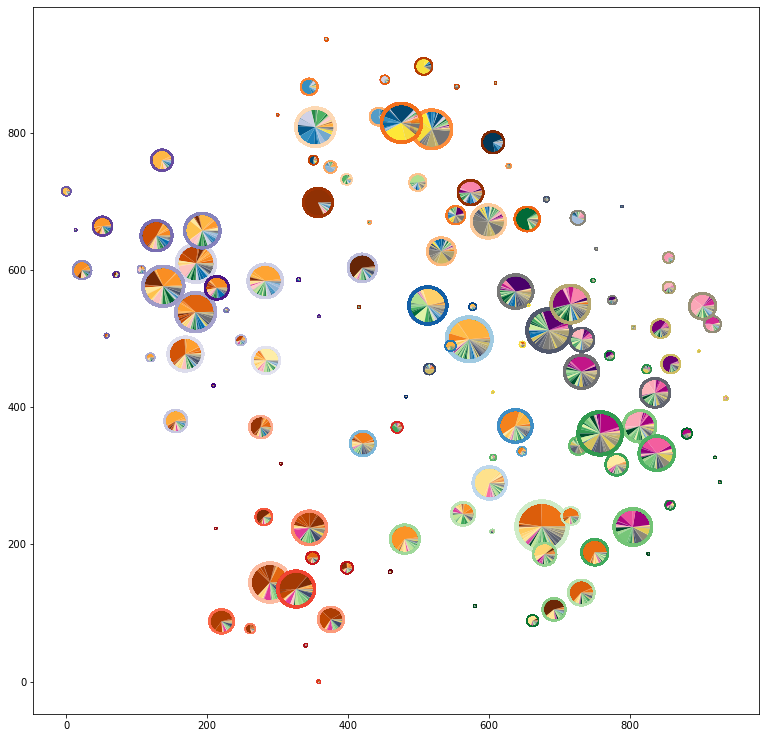

In [100]:
V1 = PolygonColorByType2(TMG,name = 'custom',lvl=1,metric = 'cosine')
V1.cmap_list = ['YlOrBr','RdPu','YlGn','PuBu','cividis']
# V1.cmap_list = ['summer','spring','cool','Wistia']
V1.set_view()
V1.plot()

V3 = PolygonColorByType2(TMG,name = 'custom',lvl=3,metric = 'jensenshannon')
V3.set_view()
V3.plot(V1)

Text(0, 0.5, 'Freq')

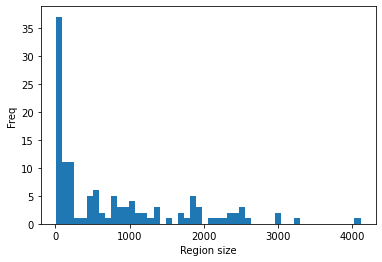

In [10]:
plt.hist(V3.sz,bins=50);
plt.xlabel("Region size")
plt.ylabel("Freq")

(-621.6086478203424, 709.0366317087198)

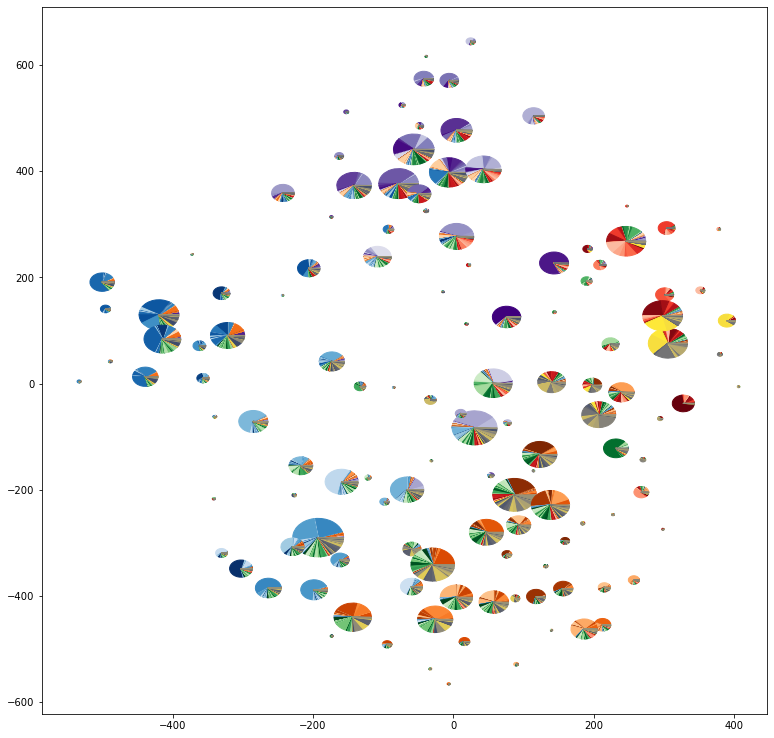

In [53]:
xy = V3.xy*100
sz = V3.sz
radi = np.sqrt(sz/np.pi)
cdf_in_angles = np.cumsum(np.hstack((np.zeros((frac.shape[0],1)),frac)),axis=1)*360

wedges = list()
for i in range(frac.shape[0]):
    for j in range(frac.shape[1]):
        w = Wedge((xy[i,0],xy[i,1]), radi[i], cdf_in_angles[i,j], cdf_in_angles[i,j+1],color = clr[j,:])
        wedges.append(w)

plt.figure(figsize = (13,13))
ax = plt.gca()
p = PatchCollection(wedges,match_original=True)
ax.add_collection(p)

mx = np.max(xy,axis=0)*1.1
mn = np.min(xy,axis=0)*1.1
ax.set_xlim(mn[0],mx[0])
ax.set_ylim(mn[1],mx[1])
        


In [35]:
len(wedges)

14875

In [33]:
radi

array([19.35589667, 27.83462346, 23.47327018,  7.85825158, 32.00004537,
       17.92134691,  6.65169709, 23.69596251, 24.62479103,  7.65303986,
       27.50098707, 36.20057736, 12.93951313, 16.78404746, 24.16154654,
       18.3860028 , 28.26021062, 12.06099573, 16.00748133, 18.08929415,
       24.30603112,  7.15876328,  8.11727457, 19.71436966, 17.30692355,
       24.39100607, 11.91495737, 26.12386641,  3.14127466,  2.8768137 ,
       16.05711705, 20.67583559, 12.82833626, 16.41006288, 26.92786513,
        1.87120516,  8.11727457, 16.15593101, 22.93831384,  9.06222658,
        8.70389297, 26.52891174, 12.79106256,  5.38202561, 20.16928443,
        8.79484521,  2.7639532 ,  1.78412412,  4.51351667,  2.70575819,
        7.50605421,  6.25716517, 28.16995822,  1.87120516,  3.69963851,
       28.86754721,  5.86323014, 27.90885686, 13.25545387, 25.07313353,
        3.47789817, 11.96826841, 24.95861469, 18.8307518 ,  4.06842895,
       15.67594438, 31.00990432, 22.1044266 , 30.91738327, 13.24

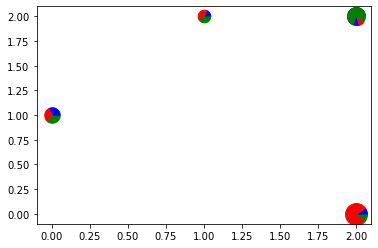

In [149]:
import numpy as np
import matplotlib.pyplot as plt

frac=np.array([[0.2,0.4,0.4],[0.33,0.33,0.33],[0.8,0.1,0.8],[0.1,0.8,0.1]])
xy=np.array([[1,2],[0,1],[2,2],[2,0]])
clr=['blue','red','green']
sizes = np.array([40,60, 80, 120])


    



In [134]:
r.shape

(3, 3)

In [131]:
len(x1)

50

In [142]:
r


array([[0.2 , 0.6 , 1.  ],
       [0.33, 0.66, 0.99],
       [0.8 , 0.9 , 1.7 ],
       [0.1 , 0.9 , 1.  ]])

array([[0.  , 0.2 , 0.6 , 1.  ],
       [0.  , 0.33, 0.66, 0.99],
       [0.  , 0.8 , 0.9 , 1.7 ],
       [0.  , 0.1 , 0.9 , 1.  ]])